### Подключение библиотек и скриптов

In [1593]:
import numpy as np
import pandas as pd
import pickle

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1594]:
import warnings
warnings.filterwarnings('ignore')

In [1595]:
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [1596]:
PREPARED_TRAIN_PATH = 'train_prepared.csv'
PREPARED_FULL_PATH = 'train_full.csv'
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_TRAIN_PATH = 'model.pkl' 
MODEL_SVN_LIFESQUARE_PATH = 'model_svm_ls.pkl' 
MODEL_TRAIN_KMEANS= 'model_kmeans.pkl'

MODEL_TRAIN_PATH_FULL = 'model_full.pkl' 


### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности
* **Social_1**, **Social_2**, **Social_3** - социальные показатели местности
* **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [1597]:
# заменяет Площади плохих кухонь (анпример больше 1000) на средние в зависимости от размера обющей площади
def Correct_BadSquare(df, IndexBadSquare, ColumnBadSquare='KitchenSquare', percentiles=[0,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999,1], ):
   
    # разбиваем датасет по колонке Square на процентили Чтобы вычислить медиану для каждого поромежутка
    qcut=pd.qcut(df.Square, percentiles)
    df_qcut=pd.DataFrame({'Interval': qcut} )
    # Вычисляем среднюю площадь кухонь  по интервалам квантелям Общей площади
    meanSquareByPeriods=df.groupby(qcut).mean()[ColumnBadSquare].rename('meanKS')
    print(meanSquareByPeriods)
    # Создаем датафрейм где в колонке Interval вставлены интервалы (квантили) площади Square, полученный с помощью qcut
    # а в колонке meanKS - средня площадь по кухням  
    df_meanKS=df_qcut.merge(meanSquareByPeriods,how='left',left_on='Interval', right_on='Square', sort=False, copy=True).set_index(df.index)
    df_meanKS
    # IndexBadKitchens= df[df['KitchenSquare']>1000].index
    df.loc[IndexBadSquare, ColumnBadSquare]= df_meanKS.loc[IndexBadSquare, 'meanKS']
    
    

In [1598]:
# заполняем LifeSquore как (Square - KitchenSquare) *0.65 def fill_LifeSquare(train_df):
# взято из последнего веб урока и является спорным для меня , например а если кухня ошибочно огромная?
# Ф-я меняет оригинальный датасет
def fill_LifeSquare(df):
    indx=(df['Square'] < df['LifeSquare'])  | (df['LifeSquare'].isna())
    print(indx.value_counts())
    df.loc[indx, 'LifeSquare'] = (df.loc[indx, 'Square'] - df.loc[indx, 'KitchenSquare'])*0.65
    return df

In [1599]:
def reduce_dims_to_2D_space_with_PCA(df):
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_PCA(df):
    pca = PCA(n_components=3)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def reduce_dims_to_2D_space_with_TSNE(df):
    tsne = TSNE(n_components=2, learning_rate=250, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_TSNE(df):
    tsne = TSNE(n_components=3, learning_rate=250, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])  

In [1600]:
def display_clusters_distribution(unique_labels, labels_counts):
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

def apply_elbow_method(X):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=labels.name, cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=labels, cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [1601]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [1602]:
# устанавливаем колонку id  как индекс у данных train
dfTest = pd.read_csv(TEST_DATASET_PATH)
dfTest.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [1603]:
dfAll=pd.concat([df,dfTest], axis=0)

In [1604]:
df=dfAll.copy()

In [1605]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [1606]:
 df.info()
# мы видим что пропуск данных есть только в колонках: LifeSquare(7887) и Healthcare_1 (5202)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Helthcare_2    15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_2

In [1607]:
# вывод nan в индексах
df[df.index.isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [1608]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [1609]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [1610]:
# устанавливаем колонку id  как индекс у данных train
df.set_index("Id", inplace=True)

In [1611]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [1612]:
# посмотрути сколько пустых значний в датасет. Как видим значительно не хватает данных Healthcare_1 и LifeSquare       

In [1613]:
# смотрим уникальные значения
df.nunique()

DistrictId         212
Rooms               10
Square           15000
LifeSquare       11846
KitchenSquare       67
Floor               37
HouseFloor          46
HouseYear          105
Ecology_1          131
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           144
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [1614]:
# заменяем некоторые параметры , котрые мы считаем дискретными 
df.replace({'Ecology_2':{'A':0, 'B':1}, 'Ecology_3':{'A':0, 'B':1}, 'Shops_2':{'A':0, 'B':1}}, inplace=True)

In [1615]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


### Анализ параметров

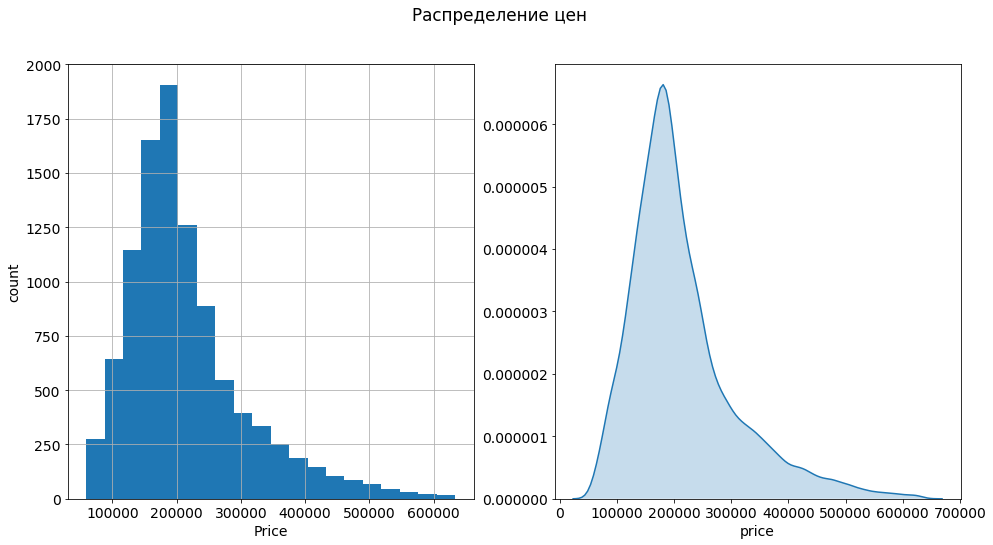

In [1616]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цен')
plt.show()

In [1617]:
# Вывод Среднего , медианы и моды Price
price_mean = round(df['Price'].mean(), 2)
price_median = df['Price'].median()
price_mode = df['Price'].mode()[0]
print(pd.DataFrame({'price_mean':[price_mean], 'price_median': [price_median], 'price_mode' :[price_mode]}))

   price_mean   price_median    price_mode
0   214138.86  192269.644879  59174.778028


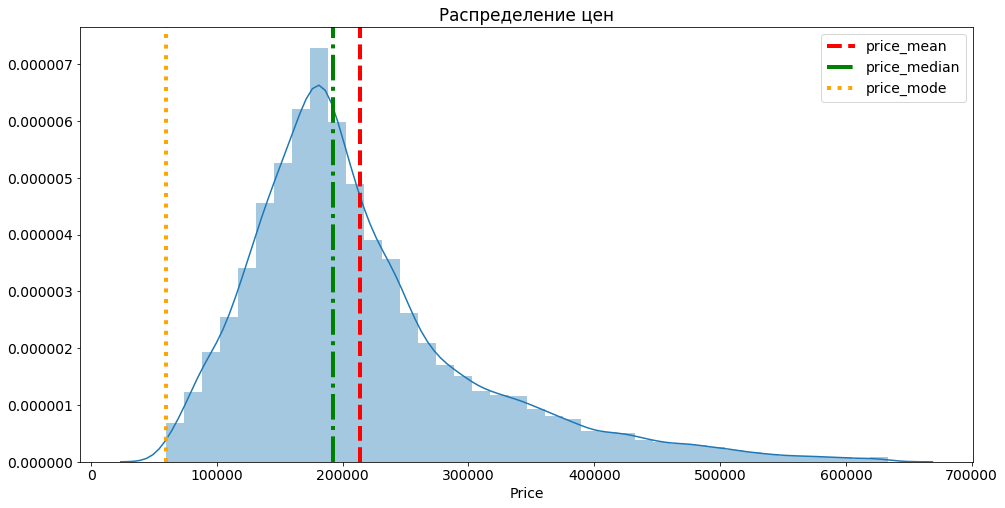

In [1618]:
# Мода Price нам не интересна так как цены все разные  
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=40)

plt.axvline(price_mean, 0, 1, label='price_mean', c='red', linestyle="--",linewidth=4)
plt.axvline(price_median, 0, 1, label='price_median', c='green', linestyle="-.",linewidth=4)
plt.axvline(price_mode, 0, 1, label='price_mode', c='orange', linestyle=":",linewidth=4)


plt.title('Распределение цен')
plt.legend()
plt.show()

In [1619]:
df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

**Количественные признаки**

In [1620]:
df_num_features = df.select_dtypes(include=['float64','int64'])
df_num_features.corr()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
DistrictId,1.000000,0.063861,-0.030043,-0.021397,0.042293,-0.123774,-0.150007,0.010853,0.070427,-0.091151,-0.035985,0.238062,0.160131,0.134509,0.307696,0.296534,0.168543,-0.020586,0.265100
Rooms,0.063861,1.000000,0.685344,0.152914,0.011596,-0.008179,-0.022225,-0.008731,-0.025705,0.004924,-0.005595,0.074193,0.070390,0.006296,0.036978,0.052050,0.048053,0.006524,0.550291
Square,-0.030043,0.685344,1.000000,0.218687,0.012461,0.113981,0.098070,-0.007613,-0.061655,0.035428,0.028856,-0.075502,-0.045846,0.025319,-0.046132,-0.036891,0.011542,-0.038208,0.520075
LifeSquare,-0.021397,0.152914,0.218687,1.000000,-0.000882,0.027075,0.032258,-0.002140,-0.023770,0.009131,0.010753,-0.049769,-0.039856,0.013081,-0.034083,-0.025998,-0.007327,-0.003750,0.081292
KitchenSquare,0.042293,0.011596,0.012461,-0.000882,1.000000,-0.010622,0.010683,0.000965,-0.003893,-0.000729,-0.009614,0.052472,0.046534,-0.017227,0.011231,0.044913,0.012194,-0.013202,0.028864
Floor,-0.123774,-0.008179,0.113981,0.027075,-0.010622,1.000000,0.434156,0.000703,-0.020034,0.040893,0.030394,-0.043501,-0.012720,0.001016,-0.131583,-0.059731,0.030623,-0.008972,0.128715
HouseFloor,-0.150007,-0.022225,0.098070,0.032258,0.010683,0.434156,1.000000,-0.000686,-0.015168,0.055269,0.013895,-0.025846,0.003794,-0.014608,-0.149781,-0.072358,0.023358,0.052703,0.088280
HouseYear,0.010853,-0.008731,-0.007613,-0.002140,0.000965,0.000703,-0.000686,1.000000,0.001166,0.000815,0.001399,0.002430,0.001569,0.000640,-0.009705,0.009205,0.003005,0.002442,0.004305
Ecology_1,0.070427,-0.025705,-0.061655,-0.023770,-0.003893,-0.020034,-0.015168,0.001166,1.000000,-0.112076,-0.212880,0.023236,0.006529,-0.122797,-0.036873,0.028627,-0.076433,0.079009,-0.058381
Ecology_2,-0.091151,0.004924,0.035428,0.009131,-0.000729,0.040893,0.055269,0.000815,-0.112076,1.000000,-0.016850,-0.062862,-0.010532,0.009216,-0.028968,-0.079934,0.052575,0.027352,0.022379


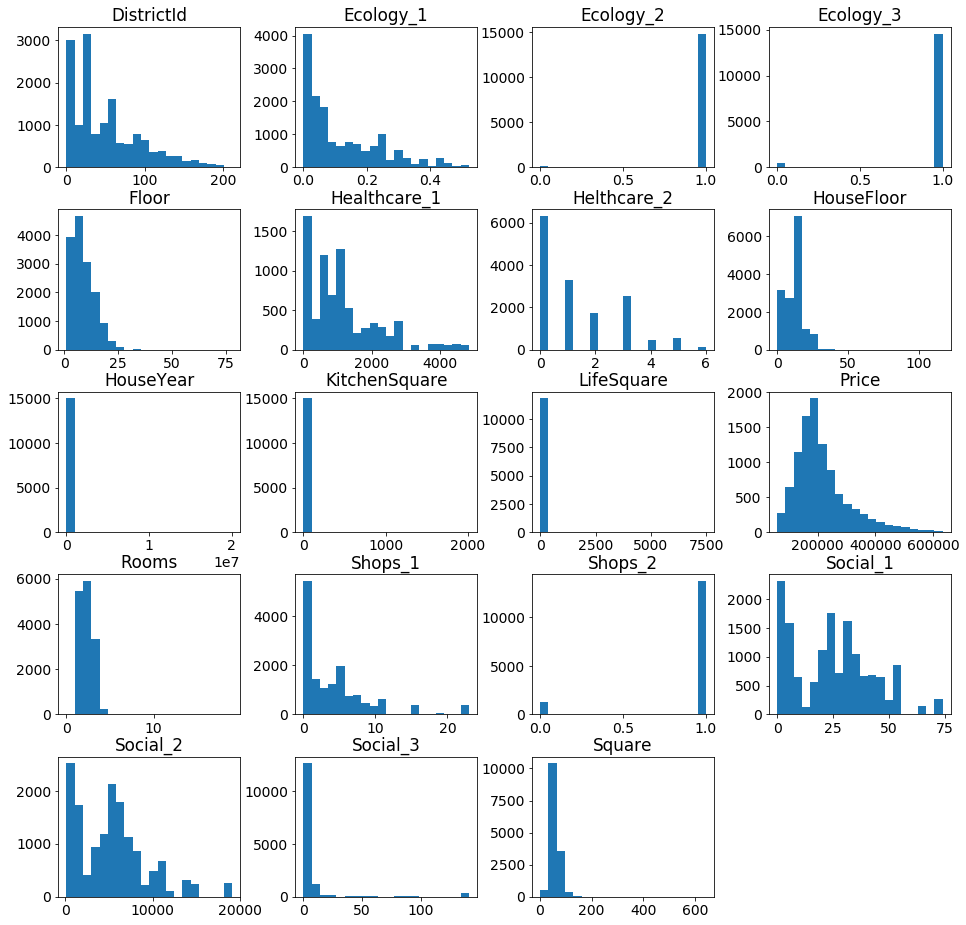

In [1621]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [1622]:
df.LifeSquare.describe()

count    11846.000000
mean        36.851792
std         71.120183
min          0.333490
25%         22.896130
50%         32.822810
75%         45.144624
max       7480.592129
Name: LifeSquare, dtype: float64

(array([1.1845e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([3.33489942e-01, 7.48359354e+02, 1.49638522e+03, 2.24441108e+03,
        2.99243695e+03, 3.74046281e+03, 4.48848867e+03, 5.23651454e+03,
        5.98454040e+03, 6.73256627e+03, 7.48059213e+03]),
 <a list of 10 Patch objects>)

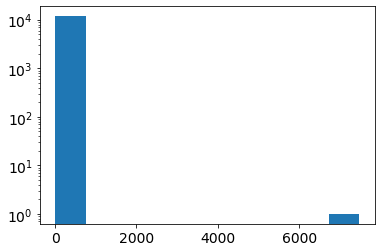

In [1623]:
# вывод гистоuраммы LifeSquare .котрая показывает выброс значения
plt.hist(df['LifeSquare'], log=True)

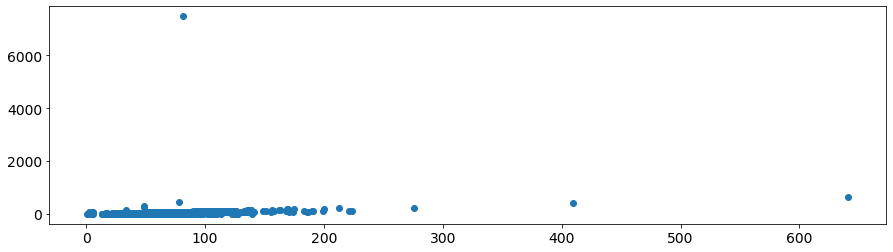

In [1624]:
# посмотрим насколько коррелируют  колонки Square и LifeSquare

#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['LifeSquare'])

In [1625]:
df1=df.copy()

In [1626]:
# на графике мы видим выброс ОШИБОЧНЫЙ ( скорей всего опечатка) по колонке LifeSquare 
# , т.к. общая площать  81.694417 а жилая 7480.592129

df[df['LifeSquare']>6000].index

Int64Index([16550], dtype='int64', name='Id')

In [1627]:
# заменим его на 74.80 Ю так кона именно корректная
df.loc[16550, 'LifeSquare']=74.80
df.loc[16550, :]

DistrictId           27.000000
Rooms                 3.000000
Square               81.694417
LifeSquare           74.800000
KitchenSquare         1.000000
Floor                 9.000000
HouseFloor           17.000000
HouseYear          2016.000000
Ecology_1             0.017647
Ecology_2             1.000000
Ecology_3             1.000000
Social_1              2.000000
Social_2            469.000000
Social_3              0.000000
Healthcare_1               NaN
Helthcare_2           0.000000
Shops_1               0.000000
Shops_2               1.000000
Price            217357.492366
Name: 16550, dtype: float64

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,108337.484207
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275
14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,NaN


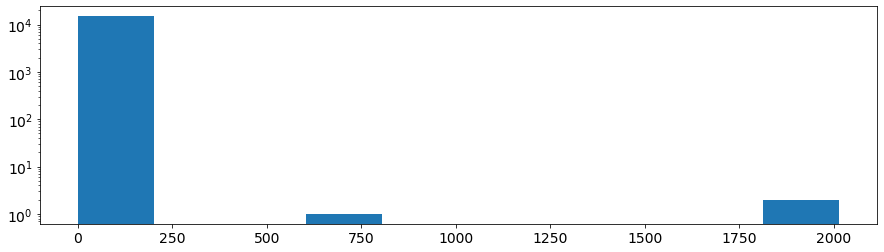

In [1628]:
# по гистонрамма выше мы видим также выброс по колонке  KitchenSquare
# вывод гистоuраммы LifeSquare .котрая показывает выброс значения
plt.hist(df['KitchenSquare'], log=True)

df[df['KitchenSquare']>250]


In [1629]:
# в наборе присутствуют данные в которых кухня больне общей площади. 
df[df['KitchenSquare']>df['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,108337.484207
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,NaN,1,0,1,160488.033165
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,NaN,0,0,1,99079.960518
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275
14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,NaN
10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,1,1,31,6119,4,NaN,1,2,1,NaN
3194,29,2.0,43.926987,31.028707,44.0,6,5.0,1964,0.086885,1,1,10,2277,2,1547.0,0,0,1,NaN
12640,6,2.0,54.629142,31.486308,97.0,4,17.0,2015,0.243205,1,1,5,1564,0,540.0,0,0,1,NaN


In [1630]:
df1=df.copy()

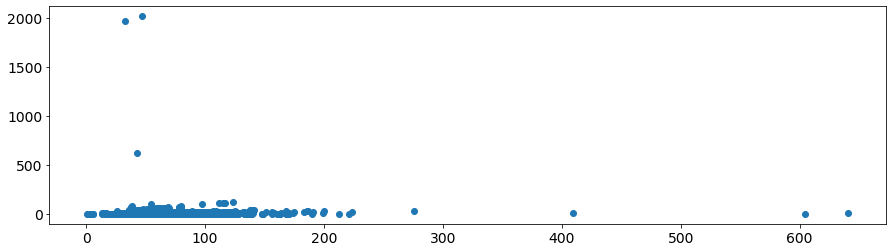

In [1631]:
# посмотрим насколько коррелируют  колонки Square и KitchenSquare
#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['KitchenSquare'])

In [1632]:
# заменяем Плохие кухни на средние 
Correct_BadSquare(df, df[df['KitchenSquare']>500].index, ColumnBadSquare='KitchenSquare')

Square
(1.1360000000000001, 4.967]     0.866667
(4.967, 29.744]                 3.651852
(29.744, 36.969]                7.024444
(36.969, 40.407]                6.206000
(40.407, 43.23]                 5.986667
(43.23, 46.932]                 5.041333
(46.932, 52.646]                6.447333
(52.646, 58.058]                6.616000
(58.058, 63.601]                5.857333
(63.601, 70.789]                5.062000
(70.789, 81.057]                6.949333
(81.057, 117.374]               6.658519
(117.374, 173.975]              8.681481
(173.975, 641.065]             14.533333
Name: meanKS, dtype: float64


In [1633]:
# Выводим только те ячесйки которые поменялись ( проверяем что поменяли именно нужные)
df.loc[df1['KitchenSquare'] != df['KitchenSquare'],:]
# все верно поменялись только верные ячейки


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,6.447333,4,1.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,108337.484207
14679,81,1.0,32.276663,19.278394,7.024444,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275
14594,11,2.0,42.795304,24.223770,5.986667,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,NaN


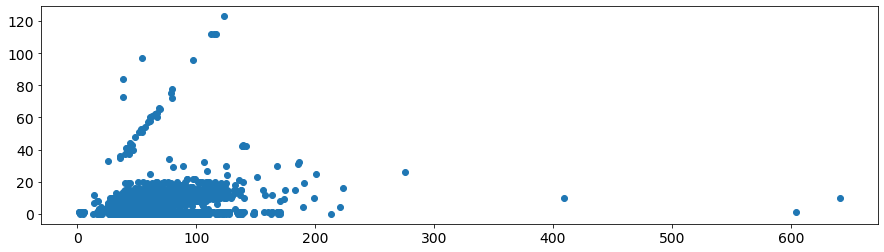

In [1634]:
# посмотрим исправились ли Кухни и проверим опять корреляцию. Кк видим Выброс кухонь изменились
#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['KitchenSquare'])

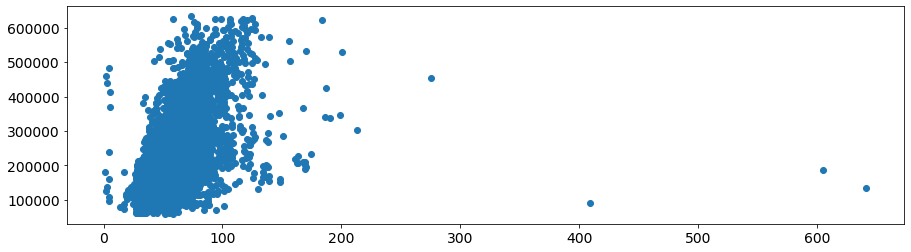

In [1635]:
# посмотрим насколько коррелируют  колонки Square и цена
#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['Price'])

In [1636]:
df1=df.copy()

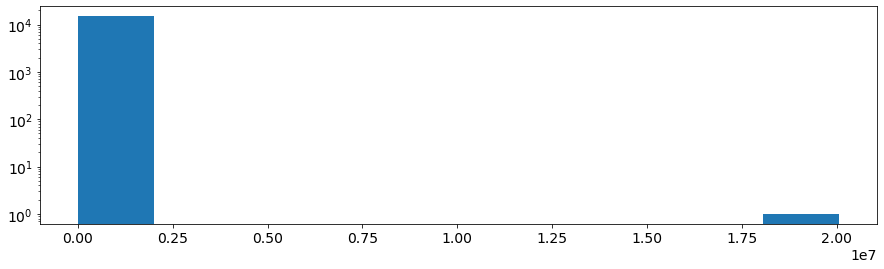

In [1637]:
plt.hist(df['HouseYear'], log=True)
# убираем даты заведома неправильные > 2020

df.loc[df['HouseYear']>2020, 'HouseYear']=int(df.loc[df['HouseYear']<2020, 'HouseYear'].median())


(array([  26.,   24.,   69.,   35., 1068., 3023., 5538., 1133., 1343.,
        2741.]),
 array([1908. , 1919.2, 1930.4, 1941.6, 1952.8, 1964. , 1975.2, 1986.4,
        1997.6, 2008.8, 2020. ]),
 <a list of 10 Patch objects>)

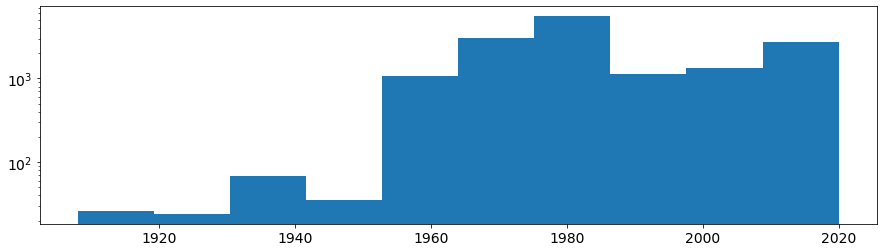

In [1638]:
# проверяем что заменили некорректные данные HouseYear на медиану
plt.hist(df['HouseYear'], log=True)

## заполнение пропущенных ячеек  колонки LifeSquare
 

In [1639]:
df_ls=df.copy()

In [1640]:
# в колонке LifeSquare незаполнены более 800 колонок. попытаемся их заполнить

In [1641]:
# columns_ls это колонки , которые будут учавствовать в обучении LifeSquare
columns_ls =['DistrictId', 'Rooms','Square','KitchenSquare','HouseFloor', 'HouseYear']

In [1642]:
# df_ls это датасет  train с ненулевыми значениями в колонке LifeSquare (а также там удален некорректный 1 выброс)
df_notNan_ls=df[df['LifeSquare'].notnull()]
df_notNan_ls.shape

(11846, 19)

In [1643]:
X=df_notNan_ls[columns_ls]
X

,DistrictId,Rooms,Square,KitchenSquare,HouseFloor,HouseYear
Id,,,,,,
14038,35,2.0,47.981561,6.0,9.0,1969
15053,41,3.0,65.683640,8.0,9.0,1978
4765,53,2.0,44.947953,0.0,12.0,1968
5809,58,2.0,53.352981,9.0,17.0,1977
10783,99,1.0,39.649192,7.0,12.0,1976
...,...,...,...,...,...,...
14562,113,2.0,46.627882,5.0,5.0,1969
6836,39,2.0,45.131282,6.0,5.0,1965
8180,11,3.0,67.133911,6.0,9.0,1973


In [1644]:
y=df_notNan_ls['LifeSquare']
y

Id
14038    29.442751
15053    40.049543
4765     29.197612
5809     52.731512
10783    23.776169
           ...    
14562    27.058739
6836     30.780551
8180     50.809797
4695     21.807061
5783     48.282625
Name: LifeSquare, Length: 11846, dtype: float64

In [1645]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,50.693600,1.897000,56.360350,36.226620,5.868831,8.561800,12.606600,1984.706733,0.119196,0.990333,0.971733,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,0.917533,214138.857399
std,43.786257,0.839229,20.423913,19.492294,5.069661,5.323113,6.780165,18.465246,0.119371,0.097846,0.165739,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,0.275084,92872.293865
min,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,212.000000,19.000000,641.065193,638.163193,123.000000,78.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [1646]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 14038 to 12504
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     15000 non-null  int64  
 1   Rooms          15000 non-null  float64
 2   Square         15000 non-null  float64
 3   LifeSquare     11846 non-null  float64
 4   KitchenSquare  15000 non-null  float64
 5   Floor          15000 non-null  int64  
 6   HouseFloor     15000 non-null  float64
 7   HouseYear      15000 non-null  int64  
 8   Ecology_1      15000 non-null  float64
 9   Ecology_2      15000 non-null  int64  
 10  Ecology_3      15000 non-null  int64  
 11  Social_1       15000 non-null  int64  
 12  Social_2       15000 non-null  int64  
 13  Social_3       15000 non-null  int64  
 14  Healthcare_1   7825 non-null   float64
 15  Helthcare_2    15000 non-null  int64  
 16  Shops_1        15000 non-null  int64  
 17  Shops_2        15000 non-null  int64  
 18  Pr

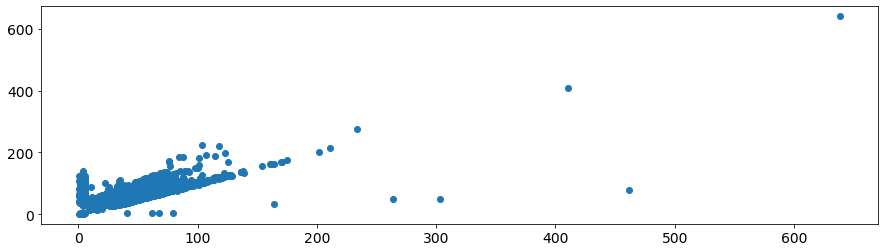

In [1647]:
plt.scatter(df1['LifeSquare'], df1['Square'])

In [1648]:
# на всякий случай сораянем датасет
df2=df.copy()

In [1649]:
#убеждаемся что пустых 2113
df2[df2['LifeSquare'].isnull()].index

Int64Index([11993,  5172, 11935,  6641,  5073,  7550, 11703,  9371,   175,
             1821,
            ...
              286,  7639,  9157, 11604,  1804,  4723, 11732,  5361,  4780,
            12504],
           dtype='int64', name='Id', length=3154)

In [1650]:

# заменяем пустые жилые комнаты  на средние 
Correct_BadSquare(df, df[df['LifeSquare'].isnull()].index, ColumnBadSquare='LifeSquare')

Square
(1.1360000000000001, 4.967]     14.842453
(4.967, 29.744]                 17.800387
(29.744, 36.969]                21.479253
(36.969, 40.407]                23.631733
(40.407, 43.23]                 25.607845
(43.23, 46.932]                 29.173209
(46.932, 52.646]                32.711291
(52.646, 58.058]                35.660854
(58.058, 63.601]                41.232671
(63.601, 70.789]                45.348216
(70.789, 81.057]                50.537207
(81.057, 117.374]               60.912515
(117.374, 173.975]              91.216306
(173.975, 641.065]             193.653148
Name: meanKS, dtype: float64


In [1651]:
# Выводим только те ячесйки которые поменялись ( проверяем что поменяли именно нужные)
df.loc[df2['LifeSquare'] != df['LifeSquare'],:]
# все верно поменялись только верные ячейки
# именно столько ми поменялись отлично

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.0,80.312926,50.537207,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1,221244.156664
5172,1,2.0,64.511437,45.348216,1.0,9,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,229102.795999
11935,27,2.0,64.711835,45.348216,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,127200.026511
6641,54,3.0,118.907612,91.216306,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,571069.052600
5073,74,2.0,82.667915,60.912515,1.0,16,17.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1,244145.827069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,95,1.0,45.542940,29.173209,0.0,6,0.0,1977,0.000699,1,1,14,3369,24,4129.0,0,3,1,NaN
11732,1,1.0,46.597283,29.173209,1.0,17,24.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,NaN
5361,53,3.0,80.102103,50.537207,1.0,13,22.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1,NaN


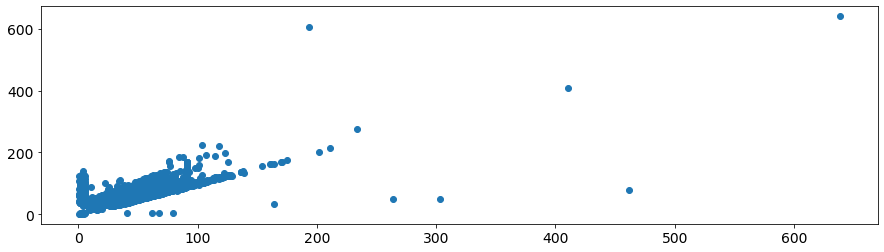

In [1652]:
# посмотрим поменяли ли зависимости lifeSquare  от Square
plt.scatter(df['LifeSquare'], df['Square'])
# видим график остался пержним - значит мы не ухудшили ситуацию. ОТлично

In [1653]:
# проверяем сколько значений LifeSquare больше Square. их 723
len(df[df['Square'] < df['LifeSquare']])

723

In [1654]:
df3=df.copy()

In [1655]:
#подправим комнаты где жилая больше общей(откуда такие данные? а нафига вообще такая колонка?)
# целых 723 и это с учетом что четверти еще и не хватает. безобразие

fill_LifeSquare(df)
df.loc[df3['LifeSquare'] != df['LifeSquare'],:]

False    14277
True       723
dtype: int64


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,42.530043,26.994528,1.0,3,9.0,2014,0.034656,1,1,0,168,0,NaN,0,0,1,95338.198549
10521,38,3.0,104.211396,67.737407,0.0,20,0.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
2301,1,2.0,61.400054,39.910035,0.0,17,22.0,2016,0.007122,1,1,1,264,0,NaN,0,1,1,199215.452229
8753,25,3.0,85.952306,55.218999,1.0,4,3.0,2017,0.069753,1,1,53,13670,4,NaN,1,11,1,309688.592681
9870,62,1.0,51.831473,33.040457,1.0,5,1.0,2015,0.072158,1,1,2,629,1,NaN,0,0,0,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14686,1,3.0,77.229885,49.549425,1.0,18,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,NaN
3711,94,1.0,41.281057,20.332687,10.0,13,13.0,2014,0.282798,1,1,33,8667,2,NaN,0,6,1,NaN
5820,94,1.0,33.680382,21.242248,1.0,10,9.0,1972,0.127376,1,1,43,8429,3,NaN,3,9,1,NaN


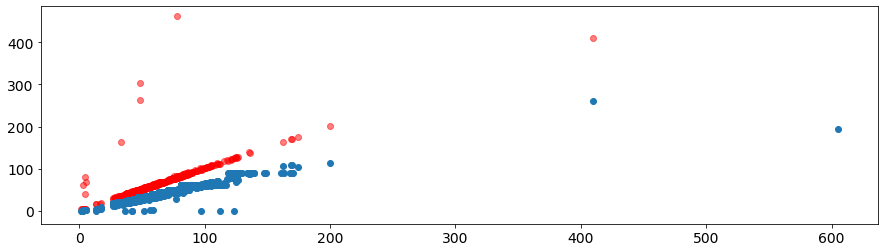

In [1656]:

# сравнение LifeSquare до Корректировки и после. где красные до изменения, а синие после
indx=df_ls[df_ls.LifeSquare != df.LifeSquare].index
df_ls.loc[indx, 'Square']
plt.scatter(df_ls.loc[indx, 'Square'],df_ls.loc[indx,'LifeSquare'], c='r', alpha=0.5)
plt.scatter(df.loc[indx, 'Square'],df.loc[indx, 'LifeSquare'] )

In [1657]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 14038 to 12504
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     15000 non-null  int64  
 1   Rooms          15000 non-null  float64
 2   Square         15000 non-null  float64
 3   LifeSquare     15000 non-null  float64
 4   KitchenSquare  15000 non-null  float64
 5   Floor          15000 non-null  int64  
 6   HouseFloor     15000 non-null  float64
 7   HouseYear      15000 non-null  int64  
 8   Ecology_1      15000 non-null  float64
 9   Ecology_2      15000 non-null  int64  
 10  Ecology_3      15000 non-null  int64  
 11  Social_1       15000 non-null  int64  
 12  Social_2       15000 non-null  int64  
 13  Social_3       15000 non-null  int64  
 14  Healthcare_1   7825 non-null   float64
 15  Helthcare_2    15000 non-null  int64  
 16  Shops_1        15000 non-null  int64  
 17  Shops_2        15000 non-null  int64  
 18  Pr

In [1658]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,50.693600,1.897000,56.360350,35.716495,5.868831,8.561800,12.606600,1984.706733,0.119196,0.990333,0.971733,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,0.917533,214138.857399
std,43.786257,0.839229,20.423913,16.521272,5.069661,5.323113,6.780165,18.465246,0.119371,0.097846,0.165739,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,0.275084,92872.293865
min,0.000000,0.000000,1.136859,0.074112,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.814371,23.631733,1.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,37.000000,2.000000,52.645757,32.805377,6.000000,7.000000,12.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,75.000000,2.000000,66.036608,45.348216,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,212.000000,19.000000,641.065193,638.163193,123.000000,78.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [1659]:
# Самые часто встречающиеся значения по признакам 
# взято с последнего вебинара
df.apply(lambda x: dict(x.value_counts().head(1)))

DistrictId                    {27.0: 1242}
Rooms                          {2.0: 5910}
Square              {81.05304359102703: 1}
LifeSquare       {45.348215750486375: 491}
KitchenSquare                  {1.0: 3651}
Floor                          {4.0: 1472}
HouseFloor                    {17.0: 3482}
HouseYear                   {1977.0: 3952}
Ecology_1               {0.007122317: 884}
Ecology_2                     {1.0: 14855}
Ecology_3                     {1.0: 14576}
Social_1                       {2.0: 1001}
Social_2                      {264.0: 884}
Social_3                       {0.0: 4467}
Healthcare_1                  {540.0: 768}
Helthcare_2                    {0.0: 6310}
Shops_1                        {0.0: 3466}
Shops_2                       {1.0: 13763}
Price                {207103.209096882: 1}
dtype: object

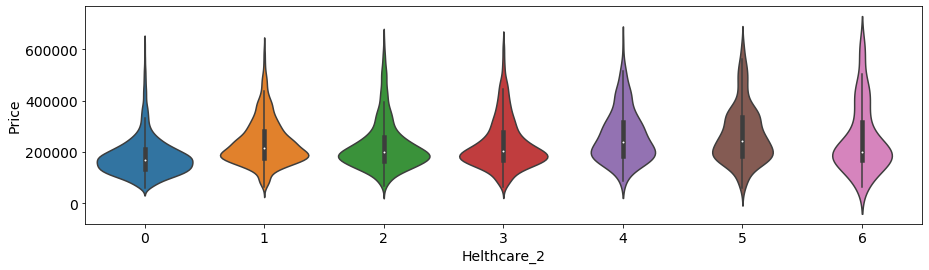

In [1660]:
# смотрим зависимости Прайса от переменной  Helthcare_2
# взято с последнего вебинара 
# здесь мы видим распределение кол-ва цен на квартиры от Helthcare_2, например в 6 больше дорогих квартир .а в 0 больше дешевых
# а в 5 увеличиваются кол-во квартир за 3000 000
sns.violinplot(df.Helthcare_2, df.Price)

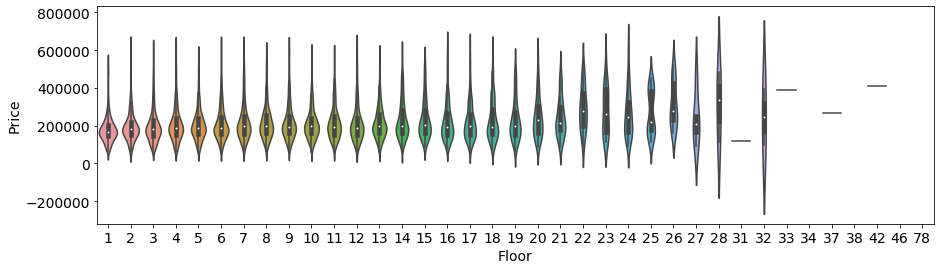

In [1661]:
sns.violinplot(df.Floor, df.Price)

### создаем  из классовых переменных в битовые

In [1662]:
# удаляем  колонку Healthcare_1, так как в ней очень мало данных, а также прайс
df_features =df.drop(['Price','Healthcare_1'], axis=1).copy()
df_features =pd.get_dummies(df_features)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 14038 to 12504
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     15000 non-null  int64  
 1   Rooms          15000 non-null  float64
 2   Square         15000 non-null  float64
 3   LifeSquare     15000 non-null  float64
 4   KitchenSquare  15000 non-null  float64
 5   Floor          15000 non-null  int64  
 6   HouseFloor     15000 non-null  float64
 7   HouseYear      15000 non-null  int64  
 8   Ecology_1      15000 non-null  float64
 9   Ecology_2      15000 non-null  int64  
 10  Ecology_3      15000 non-null  int64  
 11  Social_1       15000 non-null  int64  
 12  Social_2       15000 non-null  int64  
 13  Social_3       15000 non-null  int64  
 14  Helthcare_2    15000 non-null  int64  
 15  Shops_1        15000 non-null  int64  
 16  Shops_2        15000 non-null  int64  
dtypes: float64(6), int64(11)
memory usage: 2.1 MB


In [1669]:
df_features.columns


Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1',
       'Shops_2'],
      dtype='object')

In [1664]:
## сохраняем препарированную базу С изменнеыми LifeSquare , KitchenSquare, и Yearhouse
df_features.to_csv(PREPARED_TRAIN_PATH, index=True, encoding='utf-8')

In [1708]:
df_socium=df[[ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1',
       'Shops_2']]

In [1709]:
components_2d = reduce_dims_to_2D_space_with_PCA(df_socium)

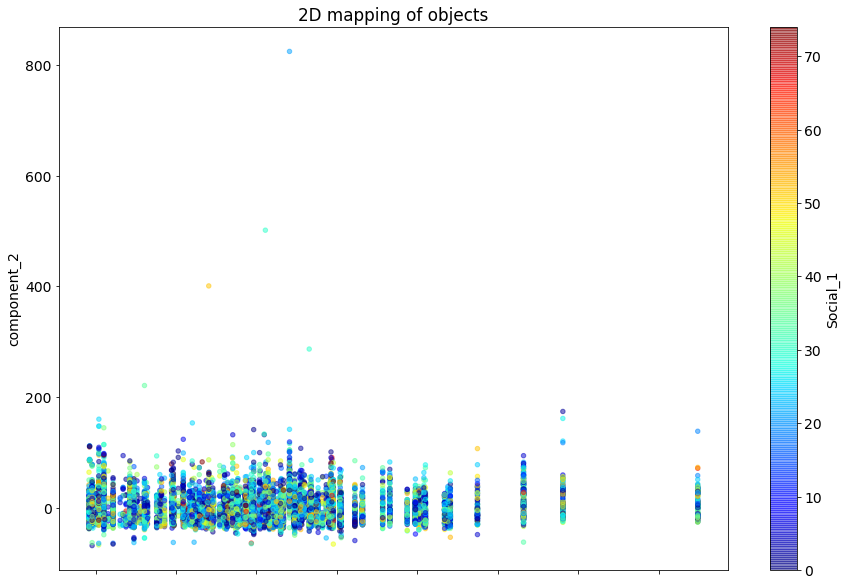

In [1746]:
display_components_in_2D_space(components_2d, df['Social_1'])

In [1711]:
**Снижение размерности до 3х компонент**

SyntaxError: invalid syntax (<ipython-input-1711-0fded209e1e7>, line 1)

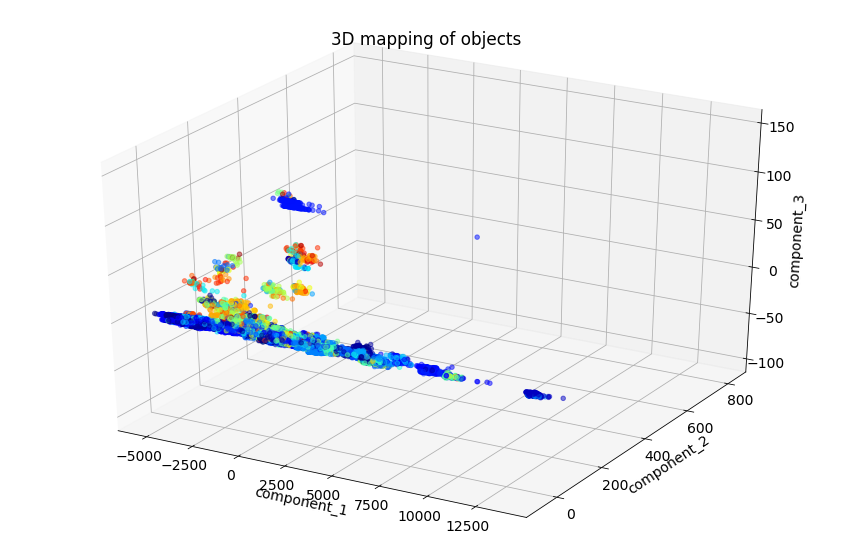

In [1717]:
df_socium=df[[ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1',
       'Shops_2']].drop([['LifeSquare']], axis=1)
components_3d = reduce_dims_to_3D_space_with_PCA(df_socium)
display_components_in_3D_space(components_3d, df['DistrictId'])

In [1755]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
                              

In [1772]:
#осчитаем главные компоненты и посмотрим на долю объяснённой дисперсии каждой компоненты.
pca = PCA(random_state=100)

pca.fit(X_train_scaled)

print(pca.explained_variance_ratio_)

[0.18526687 0.14778437 0.10751883 0.08764285 0.07097648 0.06274943
 0.05836022 0.05194776 0.04710443 0.04355397 0.03448735 0.03014735
 0.0298369  0.02140756 0.01028989 0.00891921 0.00200653]


In [1774]:
pca.explained_variance_

array([3.14974686, 2.51250172, 1.827942  , 1.49002778, 1.20668058,
       1.06681143, 0.99218993, 0.88317072, 0.80082872, 0.74046692,
       0.58632403, 0.51253919, 0.50726117, 0.36395271, 0.17493976,
       0.15163666, 0.03411323])

In [1760]:
#Посчитаем сумму первых 12 значений: Мы сохраним 92 процента использовав 12 вместо 17 параметров
# А нахрена я это сделал и что с этим делать? 
pca.explained_variance_ratio_[:12].sum()

0.9275399180708891

In [1761]:
#Ещё раз создадим модель PCA, на этот раз указав число компонент, и получим тренировочные и валидационные данные пониженной размерности:
pca = PCA(n_components=12, random_state=100)

In [1712]:
components_3d = reduce_dims_to_3D_space_with_PCA(df_socium)
components_3d

,component_1,component_2,component_3
0,2605.611795,-13.480209,0.963198
1,4938.639922,7.941460,-8.573525
2,2388.609538,-17.448133,-4.040595
3,364.578078,5.162678,-4.861840
4,405.638801,-23.075371,-2.460985
...,...,...,...
14995,621.622536,11.970054,-9.417183
14996,-5106.451720,-15.198558,-7.732441
14997,13712.671839,28.146089,-16.984225
14998,-4741.479083,28.106258,-8.618604


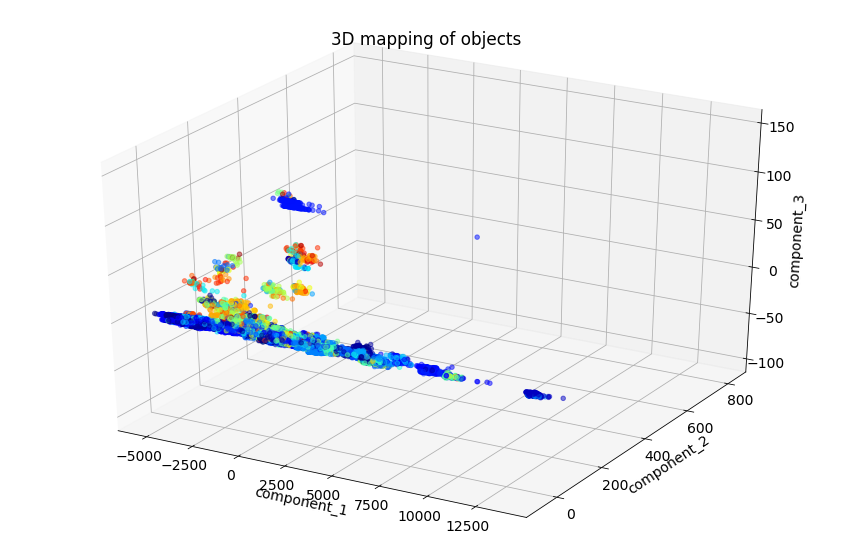

In [1716]:
display_components_in_3D_space(components_3d, df['DistrictId'])

In [ ]:
# Видим что на Колонке кластеризуются плохо

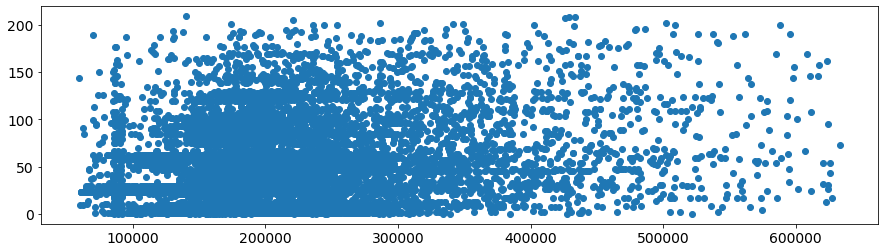

In [1697]:
plt.scatter(df.Price,df.DistrictId )

## Кластеризация: k-means

### Оценка оптимального количества кластеров методом "Локтя"

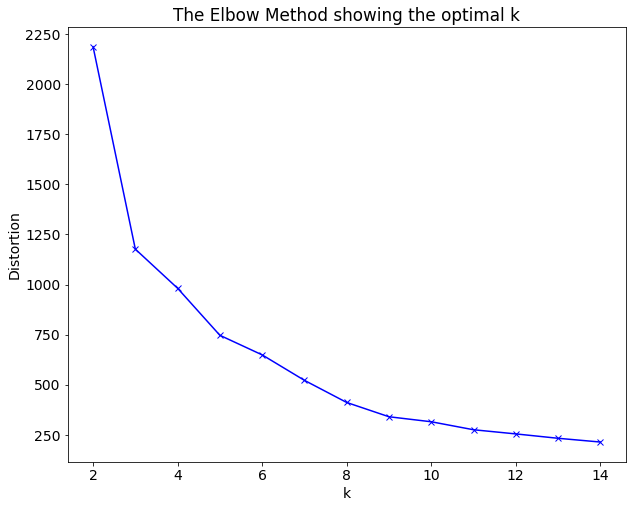

In [1479]:
apply_elbow_method(df_features)

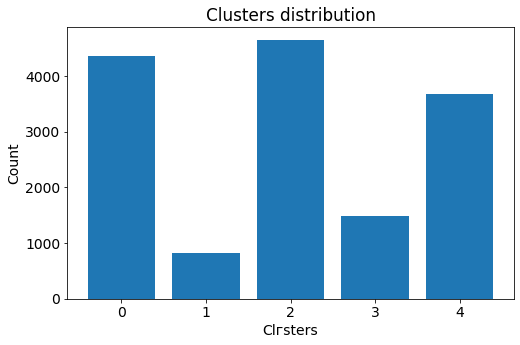

In [1480]:
# видим что при 3 -кластерах пеерстает резко уменьшаться  межкластерное расстояние
kmeans_5 = KMeans(n_clusters=5, random_state=100)
labels_clast_5 = kmeans_5.fit_predict(df_features)
labels_clast_5 = pd.Series(labels_clast_5, name='clusters_5')

unique, counts = np.unique(labels_clast_5, return_counts=True)
display_clusters_distribution(unique, counts)

In [1481]:
# сохраним модельку 
with open(MODEL_TRAIN_KMEANS, 'wb') as file:
    pickle.dump(kmeans_5, file)

In [1482]:
# установим индексы labels_clast_5 как у нашего датасета  df_features
labels_clast_5.index=df_features.index
labels_clast_5

Id
14038    4
15053    3
4765     4
5809     0
10783    0
        ..
8180     4
4695     2
5783     1
4780     2
12504    4
Name: clusters_5, Length: 15000, dtype: int32

In [1483]:
# добавим колонку  c нашими метками
df_features['components_3d']=labels_clast_5
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,0,11,1,4
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,1,16,1,3
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,1,3,1,4
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,0,5,1,0
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,1,36,5992,0,1,1,1,4
4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,1,1,264,0,0,1,1,2
5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,5,15,1,1


In [1484]:
df3=df_features.copy()

In [1485]:
# сдедаем категорию из колокнки components_3d . чтобы запустить на нее dummies
df_features['components_3d']=df_features['components_3d'].astype("category")

In [1486]:
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,0,11,1,4
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,1,16,1,3
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,1,3,1,4
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,0,5,1,0
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,1,36,5992,0,1,1,1,4
4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,1,1,264,0,0,1,1,2
5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,5,15,1,1


In [1487]:
# обработаем колонку components_3d в dummies как категорию
df_features=pd.get_dummies(df_features)
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,...,7976,5,0,11,1,0,0,0,0,1
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,...,10309,1,1,16,1,0,0,0,1,0
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,...,7759,0,1,3,1,0,0,0,0,1
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,...,5735,3,0,5,1,1,0,0,0,0
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,...,5776,1,2,4,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,...,5992,0,1,1,1,0,0,0,0,1
4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,264,0,0,1,1,0,0,1,0,0
5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,...,19083,2,5,15,1,0,1,0,0,0


In [1488]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 14038 to 12504
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DistrictId       15000 non-null  int64  
 1   Rooms            15000 non-null  float64
 2   Square           15000 non-null  float64
 3   LifeSquare       15000 non-null  float64
 4   KitchenSquare    15000 non-null  float64
 5   Floor            15000 non-null  int64  
 6   HouseFloor       15000 non-null  float64
 7   HouseYear        15000 non-null  int64  
 8   Ecology_1        15000 non-null  float64
 9   Ecology_2        15000 non-null  int64  
 10  Ecology_3        15000 non-null  int64  
 11  Social_1         15000 non-null  int64  
 12  Social_2         15000 non-null  int64  
 13  Social_3         15000 non-null  int64  
 14  Helthcare_2      15000 non-null  int64  
 15  Shops_1          15000 non-null  int64  
 16  Shops_2          15000 non-null  int64  
 17  componen

In [1489]:
# вернем колонку price перед сохранением
df_features['Price']=df['Price']
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,...,5,0,11,1,0,0,0,0,1,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,...,1,1,16,1,0,0,0,1,0,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,...,0,1,3,1,0,0,0,0,1,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,...,3,0,5,1,1,0,0,0,0,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,...,1,2,4,1,1,0,0,0,0,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,...,0,1,1,1,0,0,0,0,1,NaN
4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,0,0,1,1,0,0,1,0,0,NaN
5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,...,2,5,15,1,0,1,0,0,0,NaN


In [1490]:
## сохраняем препарированную базу С изменнеыми LifeSquare , KitchenSquare, и Yearhouse
df_features.to_csv(PREPARED_FULL_PATH, index=True, encoding='utf-8')

# ОБУЧЕНИЕ Train

In [1491]:
#https://www.kaggle.com/c/realestatepriceprediction/leaderboard
df_full=pd.read_csv(PREPARED_FULL_PATH)
# устанавливаем колонку id  как индекс у данных train
df_full.set_index("Id", inplace=True)
df_full

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,...,5,0,11,1,0,0,0,0,1,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,...,1,1,16,1,0,0,0,1,0,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,...,0,1,3,1,0,0,0,0,1,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,...,3,0,5,1,1,0,0,0,0,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,...,1,2,4,1,1,0,0,0,0,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,...,0,1,1,1,0,0,0,0,1,NaN
4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,0,0,1,1,0,0,1,0,0,NaN
5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,...,2,5,15,1,0,1,0,0,0,NaN


In [1492]:
df_full

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,...,5,0,11,1,0,0,0,0,1,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,...,1,1,16,1,0,0,0,1,0,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,...,0,1,3,1,0,0,0,0,1,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,...,3,0,5,1,1,0,0,0,0,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,...,1,2,4,1,1,0,0,0,0,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,...,0,1,1,1,0,0,0,0,1,NaN
4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,0,0,1,1,0,0,1,0,0,NaN
5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,...,2,5,15,1,0,1,0,0,0,NaN


In [1493]:
df_full1=df_full.copy()

In [1494]:
# Заменяем Districtld на Среднюю/медианную цену дома в конкретном районе
# df_full[df_full['Price'].notna()]  Это берем только строки с ценами
median_price_by_id = df_full[df_full['Price'].notna()].groupby('DistrictId')[['Price']].median().reset_index()
# пеерименовываем колонку Price в Price_Did
median_price_by_id.rename(columns={'Price': 'Price_Did'}, inplace=True)
median_price_by_id

,DistrictId,Price_Did
0,0,165963.054142
1,1,183663.443595
2,2,208539.501373
3,3,169094.013281
4,4,278639.482329
...,...,...
200,202,394150.861857
201,205,220501.566180
202,207,426186.409334
203,208,431137.654083


In [1495]:
df_full=pd.merge(df_full, median_price_by_id, how='left', on= 'DistrictId')
df_full

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price,Price_Did
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,...,0,11,1,0,0,0,0,1,184966.930730,203602.408898
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,...,1,16,1,0,0,0,1,0,300009.450063,210694.850106
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,...,1,3,1,0,0,0,0,1,220925.908524,245978.794474
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,...,0,5,1,1,0,0,0,0,175616.227217,151557.904767
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,...,2,4,1,1,0,0,0,0,150226.531644,178829.166450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,...,1,1,1,0,0,0,0,1,NaN,202852.914457
14996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,0,1,1,0,0,1,0,0,NaN,183663.443595
14997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,...,5,15,1,0,1,0,0,0,NaN,201169.579060
14998,62,2.0,81.305222,60.912515,0.0,4,0.0,1977,0.072158,1,...,0,0,0,0,0,1,0,0,NaN,162067.275050


In [1496]:
# так как мы заменили DistrictId медианой Прайса в колонке Price_Did, то убираем  кллонку DistrictId
# это тоже уменьшает чуть-чуть обучение на три тысячный. отключаем
#df_full.drop(['DistrictId'], axis=1, inplace=True)


In [1497]:
#Смотрим появились ли пропуски в датасете
df_full.isnull().sum()
# да, видимо каких то районов нет в train 

DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
components_3d_0       0
components_3d_1       0
components_3d_2       0
components_3d_3       0
components_3d_4       0
Price              5000
Price_Did             8
dtype: int64

In [1498]:
X=df_full[df_full['Price'].notna()].copy()
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price,Price_Did
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,...,0,11,1,0,0,0,0,1,184966.930730,203602.408898
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,...,1,16,1,0,0,0,1,0,300009.450063,210694.850106
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,...,1,3,1,0,0,0,0,1,220925.908524,245978.794474
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,...,0,5,1,1,0,0,0,0,175616.227217,151557.904767
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,...,2,4,1,1,0,0,0,0,150226.531644,178829.166450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,1,...,3,11,1,0,0,0,0,1,196684.316040,234647.811956
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,1,...,0,5,0,1,0,0,0,0,189050.289571,188489.490556
9997,27,1.0,47.939008,32.711291,1.0,12,16.0,2015,0.072158,1,...,0,0,0,0,0,1,0,0,159143.805370,146171.433190
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,1,...,2,5,1,1,0,0,0,0,181595.339808,194932.010500


In [1499]:
XTest=df_full[df_full['Price'].isna()].copy()
XTest.drop(['Price'], axis=1, inplace=True)
XTest

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price_Did
10000,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,...,1,0,0,1,0,0,1,0,0,151557.904767
10001,74,2.0,69.263183,45.348216,1.0,6,1.0,1977,0.075779,1,...,3,0,2,1,0,0,1,0,0,195610.960042
10002,190,1.0,13.597819,1.038582,12.0,2,5.0,1909,0.000000,1,...,87,5,5,1,0,0,0,0,1,526438.458919
10003,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,...,3,3,3,1,1,0,0,0,0,196429.659238
10004,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,...,1,0,0,0,0,0,1,0,0,146171.433190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,...,0,1,1,1,0,0,0,0,1,202852.914457
14996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,0,0,1,1,0,0,1,0,0,183663.443595
14997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,...,2,5,15,1,0,1,0,0,0,201169.579060
14998,62,2.0,81.305222,60.912515,0.0,4,0.0,1977,0.072158,1,...,1,0,0,0,0,0,1,0,0,162067.275050


In [1500]:
columns=X.columns
columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'components_3d_0', 'components_3d_1', 'components_3d_2',
       'components_3d_3', 'components_3d_4', 'Price', 'Price_Did'],
      dtype='object')

In [1501]:
y=X['Price']
y

0       184966.930730
1       300009.450063
2       220925.908524
3       175616.227217
4       150226.531644
            ...      
9995    196684.316040
9996    189050.289571
9997    159143.805370
9998    181595.339808
9999    218714.077615
Name: Price, Length: 10000, dtype: float64

In [1502]:
X.drop(['Price'], axis=1, inplace=True)
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price_Did
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,...,5,0,11,1,0,0,0,0,1,203602.408898
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,...,1,1,16,1,0,0,0,1,0,210694.850106
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,...,0,1,3,1,0,0,0,0,1,245978.794474
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,...,3,0,5,1,1,0,0,0,0,151557.904767
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,...,1,2,4,1,1,0,0,0,0,178829.166450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,1,...,6,3,11,1,0,0,0,0,1,234647.811956
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,1,...,0,0,5,0,1,0,0,0,0,188489.490556
9997,27,1.0,47.939008,32.711291,1.0,12,16.0,2015,0.072158,1,...,1,0,0,0,0,0,1,0,0,146171.433190
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,1,...,9,2,5,1,1,0,0,0,0,194932.010500


In [1503]:
# разобьем наш датасет , презназначенный для обучения колонки LifeSquare на два датасета (обучающего и валидного)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=50)
X_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price_Did
5189,58,1.0,43.230274,29.173209,1.0,13,17.0,1977,0.437885,1,...,3,0,5,1,1,0,0,0,0,151557.904767
7969,101,1.0,31.857473,22.659669,5.0,3,9.0,1966,0.225825,0,...,7,3,2,1,0,0,0,0,1,184276.502773
9039,58,1.0,44.063070,29.173209,1.0,3,1.0,1977,0.437885,1,...,3,0,5,1,1,0,0,0,0,151557.904767
5208,48,1.0,41.812188,21.079607,8.0,2,12.0,1981,0.041125,1,...,5,1,10,1,0,0,0,1,0,240288.274803
506,23,1.0,105.432181,68.530917,0.0,3,2.0,1977,0.014073,1,...,0,0,0,1,0,0,1,0,0,113789.561738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262,27,1.0,40.422035,40.262914,1.0,8,17.0,2016,0.011654,1,...,0,0,0,1,0,0,1,0,0,146171.433190
6214,31,3.0,50.914858,39.397964,4.0,4,4.0,1960,0.151346,1,...,10,4,1,1,1,0,0,0,0,305054.496719
8324,30,2.0,66.144841,45.348216,1.0,8,17.0,1977,0.000078,1,...,141,3,23,1,0,0,0,0,1,164259.100469
6253,19,1.0,42.674884,21.245851,10.0,4,16.0,1978,0.309479,1,...,4,0,6,1,0,0,0,0,1,195151.001421


In [1725]:
from sklearn.ensemble import RandomForestRegressor
parameters = {
    'n_estimators': [100, 150],
    'max_features': np.arange(8, 9),
    'max_depth': np.arange(8, 12),
}

model = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)
model

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [1505]:
# 0.8685995690298893  -vadim, 0.8685995690298893-artem
model = RandomForestRegressor(max_depth=11, n_estimators=150, max_features=8, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
r2_score(y_train, y_pred)
#0.8717689079260753
#0.8939469168412129

0.8938784885878949

In [1506]:
f_importance = pd.DataFrame()
f_importance['name'] = X_train.columns.tolist()
f_importance['values'] = model.feature_importances_
f_importance.sort_values('values', ascending = False).reset_index(drop=True)

,name,values
0,Square,0.285753
1,Price_Did,0.201690
2,Rooms,0.112108
3,LifeSquare,0.077662
4,Social_1,0.055608
5,Social_2,0.054184
6,Social_3,0.033627
7,KitchenSquare,0.032024
8,HouseYear,0.026453
9,DistrictId,0.023785


In [1729]:
# 0.7488109805512833 -vadim, 0.7488453749310405 - artem   , 0.7491432139948219 -vadim +LS
y_valid_pred = model.predict(X_valid)
r2_score(y_valid, y_valid_pred)
#0.7580933133284932

0.7564782258102818

In [1508]:
# сохраним модель
with open(MODEL_TRAIN_PATH, 'wb') as file:
    pickle.dump(model, file)

In [1509]:
# full 3 comp  0.8609185713105426
model = RandomForestRegressor(max_depth=11, n_estimators=100, max_features=8, random_state=50)
model.fit(X, y)
y_pred_full = model.predict(X)
r2_score(y, y_pred_full)
# 0.8830720951975526

0.8806858652148871

In [1510]:
# сохраним модель
with open(MODEL_TRAIN_PATH_FULL, 'wb') as file:
    pickle.dump(model, file)

# Обучим TEST

In [1511]:
XTest

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,components_3d_0,components_3d_1,components_3d_2,components_3d_3,components_3d_4,Price_Did
10000,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,...,1,0,0,1,0,0,1,0,0,151557.904767
10001,74,2.0,69.263183,45.348216,1.0,6,1.0,1977,0.075779,1,...,3,0,2,1,0,0,1,0,0,195610.960042
10002,190,1.0,13.597819,1.038582,12.0,2,5.0,1909,0.000000,1,...,87,5,5,1,0,0,0,0,1,526438.458919
10003,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,...,3,3,3,1,1,0,0,0,0,196429.659238
10004,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,...,1,0,0,0,0,0,1,0,0,146171.433190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,...,0,1,1,1,0,0,0,0,1,202852.914457
14996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,0,0,1,1,0,0,1,0,0,183663.443595
14997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,...,2,5,15,1,0,1,0,0,0,201169.579060
14998,62,2.0,81.305222,60.912515,0.0,4,0.0,1977,0.072158,1,...,1,0,0,0,0,0,1,0,0,162067.275050


In [1512]:
# прочитаем нашу ранее сохраненную модель  
with open(MODEL_TRAIN_PATH_FULL, 'rb') as file:
    model=pickle.load(file)

In [1514]:
# видим что есть пустые значения Price_Did. заполнянем средними
XTest.isnull().sum()
XTest.loc[XTest['Price_Did'].isna(), 'Price_Did']= XTest['Price_Did'].median()
XTest.isnull().sum()

DistrictId         0
Rooms              0
Square             0
LifeSquare         0
KitchenSquare      0
Floor              0
HouseFloor         0
HouseYear          0
Ecology_1          0
Ecology_2          0
Ecology_3          0
Social_1           0
Social_2           0
Social_3           0
Helthcare_2        0
Shops_1            0
Shops_2            0
components_3d_0    0
components_3d_1    0
components_3d_2    0
components_3d_3    0
components_3d_4    0
Price_Did          0
dtype: int64

In [1515]:

Price_pred = model.predict(XTest)
Price_pred

array([158778.04581363, 228696.02189938, 309322.81135699, ...,
       328422.00804751, 201854.82085964, 173719.073065  ])

AttributeError: 'RandomForestRegressor' object has no attribute 'cv_results_'

In [1516]:
pd_Price=pd.DataFrame({'Id': XTest.index, 'Price':Price_pred})
pd_Price

,Id,Price
0,10000,158778.045814
1,10001,228696.021899
2,10002,309322.811357
3,10003,321016.005286
4,10004,139499.440723
...,...,...
4995,14995,253534.104826
4996,14996,135490.516665
4997,14997,328422.008048
4998,14998,201854.820860


In [1517]:
pd_Price.describe()

,Id,Price
count,5000.000000,5000.000000
mean,12499.500000,215577.088959
std,1443.520003,77208.812147
min,10000.000000,67825.864439
25%,11249.750000,165617.660573
50%,12499.500000,197002.952722
75%,13749.250000,248115.251351
max,14999.000000,568118.213166


In [1518]:
# сохраняем препарированную базу без добавления обученых LifeSquare
pd_Price.to_csv('AKolyvanov_predictions_20200826-1.csv', index=False, encoding='utf-8')